## 构建四种相关系数因子

In [9]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm

def calculate_all_factors_vectorized(df):
    """
    向量化计算所有四个相关系数因子。
    - rvc_cor: return vs volume_ratio
    - rhl_cor: return vs hl_change
    - voh_cor: return vs volume_ratio (for return > 0)
    - vol_cor: return vs volume_ratio (for return < 0)
    """
    # 1. 计算全样本相关系数 (rvc_cor, rhl_cor)
    return_pivot = df.pivot_table(index='time', columns='stock_code', values='return')
    volume_ratio_pivot = df.pivot_table(index='time', columns='stock_code', values='volume_ratio')
    hl_change_pivot = df.pivot_table(index='time', columns='stock_code', values='hl_change')

    rvc_cor = return_pivot.corrwith(volume_ratio_pivot)
    rhl_cor = return_pivot.corrwith(hl_change_pivot)

    # 2. 计算正收益样本相关系数 (voh_cor)
    pos_df = df[df['return'] > 0]
    if not pos_df.empty:
        pos_return_pivot = pos_df.pivot_table(index='time', columns='stock_code', values='return')
        pos_volume_pivot = pos_df.pivot_table(index='time', columns='stock_code', values='volume_ratio')
        voh_cor = pos_return_pivot.corrwith(pos_volume_pivot)
    else:
        voh_cor = pd.Series(dtype='float64')

    # 3. 计算负收益样本相关系数 (vol_cor)
    neg_df = df[df['return'] < 0]
    if not neg_df.empty:
        neg_return_pivot = neg_df.pivot_table(index='time', columns='stock_code', values='return')
        neg_volume_pivot = neg_df.pivot_table(index='time', columns='stock_code', values='volume_ratio')
        vol_cor = neg_return_pivot.corrwith(neg_volume_pivot)
    else:
        vol_cor = pd.Series(dtype='float64')

    # 4. 合并结果
    return pd.DataFrame({
        'rvc_cor': rvc_cor,
        'rhl_cor': rhl_cor,
        'voh_cor': voh_cor,
        'vol_cor': vol_cor
    })

def process_and_save_factors():
    """
    主函数：循环处理文件，计算所有因子，并分别保存。
    """
    data_dir = r'E:\需要拷的数据\L1_01'
    all_files = sorted(glob.glob(os.path.join(data_dir, '*.feather')))
    
    factor_names = ['rvc_cor', 'rhl_cor', 'voh_cor', 'vol_cor']
    results_collector = {name: [] for name in factor_names}

    for file in tqdm(all_files, desc="Processing files"):
        try:
            date_str = os.path.basename(file).split('.')[0]
            df = pd.read_feather(file)
            
            # 数据预处理
            df = df[(df['time'] >= 94500) & (df['time'] <= 144500)]
            df['return'] = df.groupby('stock_code')['close'].pct_change()
            df['volume_ratio'] = df.groupby('stock_code')['volume'].transform(lambda x: x / x.sum())
            df['hl_change'] = (df['high'] - df['low']) / df['low']
            df = df.dropna(subset=['return', 'volume_ratio', 'hl_change'])

            if df.empty:
                continue
            
            # 一次性计算当天的所有因子
            daily_factors = calculate_all_factors_vectorized(df)
            
            # 分别存储每个因子的每日结果
            for name in factor_names:
                if not daily_factors[name].empty:
                    daily_result = daily_factors[name].to_frame(date_str).T
                    daily_result.index = pd.to_datetime(daily_result.index)
                    results_collector[name].append(daily_result)

        except Exception as e:
            print(f"处理文件 {os.path.basename(file)} 时出错: {e}")
            continue
    
    # 合并并保存每个因子的结果
    output_path_base = r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages'
    os.makedirs(output_path_base, exist_ok=True)
    
    final_dfs = {}
    print("\n--- 处理完成，开始保存结果 ---")
    for name, data_list in results_collector.items():
        if data_list:
            final_df = pd.concat(data_list).sort_index()
            final_df.columns = final_df.columns.astype(str).str.zfill(6)
            
            # 保存为 CSV 和 Pickle
            #final_df.to_csv(os.path.join(output_path_base, f'{name}.csv'))
            final_df.to_pickle(os.path.join(output_path_base, f'{name}.pkl'))
            
            final_dfs[name] = final_df
            print(f"因子 '{name}' 已保存，形状: {final_df.shape}")
        else:
            print(f"因子 '{name}' 未计算出任何结果。")
            
    return final_dfs

if __name__ == "__main__":
    final_factors_results = process_and_save_factors()

Processing files: 100%|██████████| 2785/2785 [2:29:00<00:00,  3.21s/it]  



--- 处理完成，开始保存结果 ---
因子 'rvc_cor' 已保存，形状: (2785, 5817)
因子 'rhl_cor' 已保存，形状: (2785, 5817)
因子 'voh_cor' 已保存，形状: (2785, 5817)
因子 'vol_cor' 已保存，形状: (2785, 5817)


In [2]:
import pandas as pd
rvc_cor = pd.read_pickle(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\rvc_cor.pkl')
rhl_cor = pd.read_pickle(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\rhl_cor.pkl')
voh_cor = pd.read_pickle(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\voh_cor.pkl')
vol_cor = pd.read_pickle(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\vol_cor.pkl')

In [3]:
rvc_cor.index = rvc_cor.index.astype(str)
rhl_cor.index = rhl_cor.index.astype(str)
voh_cor.index = voh_cor.index.astype(str)
vol_cor.index = vol_cor.index.astype(str)

load data locally from 2009-01-05 to 2025-04-15
2015-05-28 极端市场，不调仓
2015-06-01 极端市场，不调仓
2015-06-19 极端市场，不调仓
2015-06-26 极端市场，不调仓
2015-06-29 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-07-02 极端市场，不调仓
2015-07-03 极端市场，不调仓
2015-07-06 极端市场，不调仓
2015-07-07 极端市场，不调仓
2015-07-08 极端市场，不调仓
2015-07-09 极端市场，不调仓
2015-07-10 极端市场，不调仓
2015-07-13 极端市场，不调仓
2015-07-14 极端市场，不调仓
2015-07-15 极端市场，不调仓
2015-07-16 极端市场，不调仓
2015-07-17 极端市场，不调仓
2015-07-20 极端市场，不调仓
2015-07-27 极端市场，不调仓
2015-07-28 极端市场，不调仓
2015-07-29 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-08-04 极端市场，不调仓
2015-08-10 极端市场，不调仓
2015-08-18 极端市场，不调仓
2015-08-21 极端市场，不调仓
2015-08-24 极端市场，不调仓
2015-08-25 极端市场，不调仓
2015-08-26 极端市场，不调仓
2015-08-28 极端市场，不调仓
2015-09-01 极端市场，不调仓
2015-09-02 极端市场，不调仓
2015-09-14 极端市场，不调仓
2015-09-15 极端市场，不调仓
2015-09-16 极端市场，不调仓
2015-10-21 极端市场，不调仓
2016-01-04 极端市场，不调仓
2016-01-07 极端市场，不调仓
2016-01-11 极端市场，不调仓
2016-01-26 极端市场，不调仓
2016-02-25 极端市场，不调仓
2018-06-19 极端市场，不调仓
2018-10-11 极端市场，不调仓
2020-02-03 极端市场，不调仓
2025-04-07 极端市场，不调仓
多头超额:
             2014   2015  

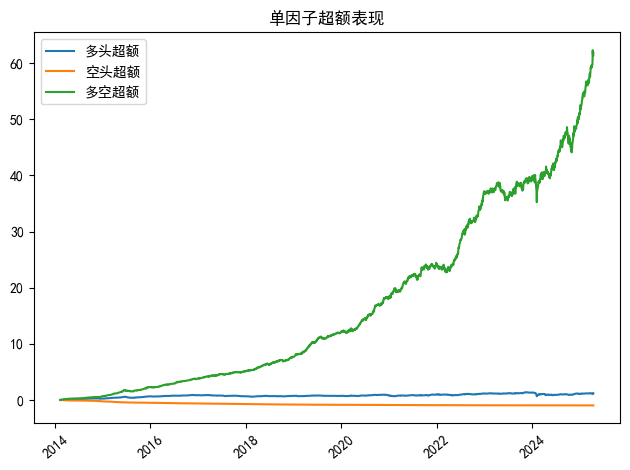

平均单边换手：0.839
年化交易成本:77.438 (未在超额中扣除)


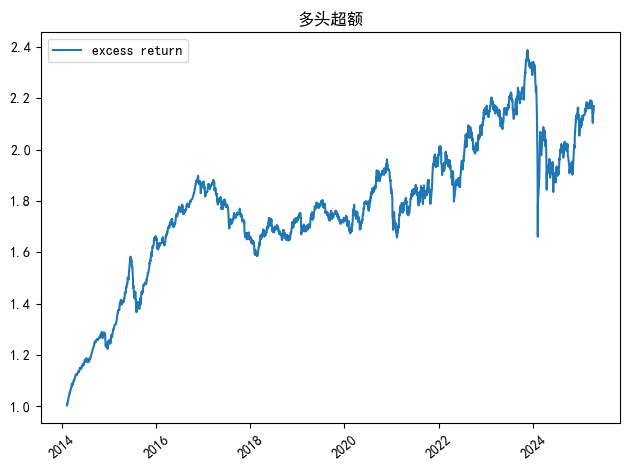

Rank IC: 2.12%
Rank ICIR: 0.23
t值: 11.90
年化收益率: 8.92%
年化波动率: 9.42%
信息比率: 0.95
最大回撤: 33.39%


In [15]:
import config
res=config.backtest_stand(-rvc_cor,top=300,fre='day',stock_pool='888888')
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

load data locally from 2009-01-05 to 2025-04-15
2015-05-28 极端市场，不调仓
2015-06-01 极端市场，不调仓
2015-06-19 极端市场，不调仓
2015-06-26 极端市场，不调仓
2015-06-29 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-07-02 极端市场，不调仓
2015-07-03 极端市场，不调仓
2015-07-06 极端市场，不调仓
2015-07-07 极端市场，不调仓
2015-07-08 极端市场，不调仓
2015-07-09 极端市场，不调仓
2015-07-10 极端市场，不调仓
2015-07-13 极端市场，不调仓
2015-07-14 极端市场，不调仓
2015-07-15 极端市场，不调仓
2015-07-16 极端市场，不调仓
2015-07-17 极端市场，不调仓
2015-07-20 极端市场，不调仓
2015-07-27 极端市场，不调仓
2015-07-28 极端市场，不调仓
2015-07-29 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-08-04 极端市场，不调仓
2015-08-10 极端市场，不调仓
2015-08-18 极端市场，不调仓
2015-08-21 极端市场，不调仓
2015-08-24 极端市场，不调仓
2015-08-25 极端市场，不调仓
2015-08-26 极端市场，不调仓
2015-08-28 极端市场，不调仓
2015-09-01 极端市场，不调仓
2015-09-02 极端市场，不调仓
2015-09-14 极端市场，不调仓
2015-09-15 极端市场，不调仓
2015-09-16 极端市场，不调仓
2015-10-21 极端市场，不调仓
2016-01-04 极端市场，不调仓
2016-01-07 极端市场，不调仓
2016-01-11 极端市场，不调仓
2016-01-26 极端市场，不调仓
2016-02-25 极端市场，不调仓
2018-06-19 极端市场，不调仓
2018-10-11 极端市场，不调仓
2020-02-03 极端市场，不调仓
2025-04-07 极端市场，不调仓
多头超额:
             2014   2015  

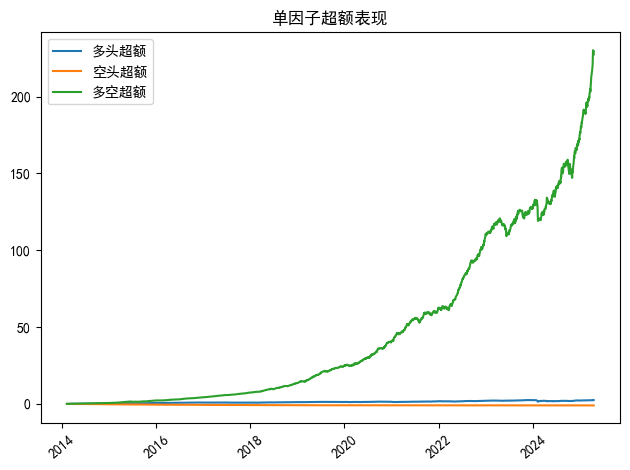

平均单边换手：0.844
年化交易成本:80.697 (未在超额中扣除)


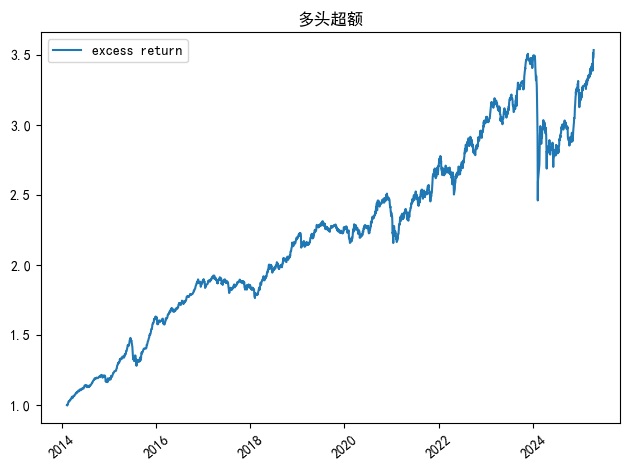

Rank IC: 2.56%
Rank ICIR: 0.35
t值: 18.45
年化收益率: 15.31%
年化波动率: 8.92%
信息比率: 1.72
最大回撤: 34.03%


In [5]:
res2=config.backtest_stand(-rhl_cor,top=300,fre='day',stock_pool='888888')
# Rank IC
rank_ic = res2['ic']['ic'].mean()
# Rank ICIR
rank_icir = res2['ic']['ic'].mean() / res2['ic']['ic'].std()
# t值
t_value = res2['ic']['ic'].mean() / (res2['ic']['ic'].std() / np.sqrt(res2['ic']['ic'].count()))
perf = res2['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

load data locally from 2009-01-05 to 2025-04-15
2015-05-28 极端市场，不调仓
2015-06-01 极端市场，不调仓
2015-06-19 极端市场，不调仓
2015-06-26 极端市场，不调仓
2015-06-29 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-07-02 极端市场，不调仓
2015-07-03 极端市场，不调仓
2015-07-06 极端市场，不调仓
2015-07-07 极端市场，不调仓
2015-07-08 极端市场，不调仓
2015-07-09 极端市场，不调仓
2015-07-10 极端市场，不调仓
2015-07-13 极端市场，不调仓
2015-07-14 极端市场，不调仓
2015-07-15 极端市场，不调仓
2015-07-16 极端市场，不调仓
2015-07-17 极端市场，不调仓
2015-07-20 极端市场，不调仓
2015-07-27 极端市场，不调仓
2015-07-28 极端市场，不调仓
2015-07-29 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-08-04 极端市场，不调仓
2015-08-10 极端市场，不调仓
2015-08-18 极端市场，不调仓
2015-08-21 极端市场，不调仓
2015-08-24 极端市场，不调仓
2015-08-25 极端市场，不调仓
2015-08-26 极端市场，不调仓
2015-08-28 极端市场，不调仓
2015-09-01 极端市场，不调仓
2015-09-02 极端市场，不调仓
2015-09-14 极端市场，不调仓
2015-09-15 极端市场，不调仓
2015-09-16 极端市场，不调仓
2015-10-21 极端市场，不调仓
2016-01-04 极端市场，不调仓
2016-01-07 极端市场，不调仓
2016-01-11 极端市场，不调仓
2016-01-26 极端市场，不调仓
2016-02-25 极端市场，不调仓
2018-06-19 极端市场，不调仓
2018-10-11 极端市场，不调仓
2020-02-03 极端市场，不调仓
2025-04-07 极端市场，不调仓
多头超额:
             2014   2015  

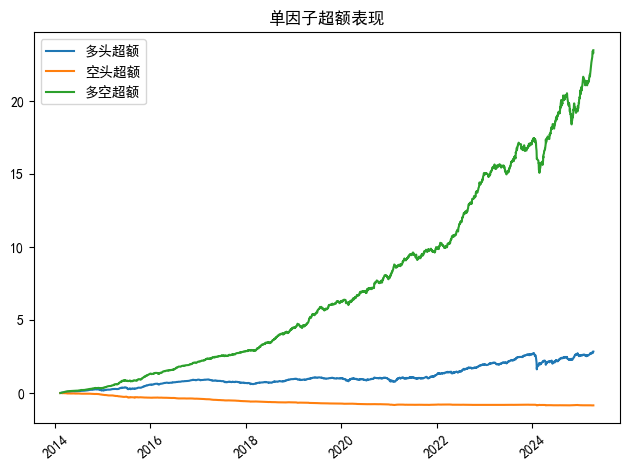

平均单边换手：0.781
年化交易成本:48.444 (未在超额中扣除)


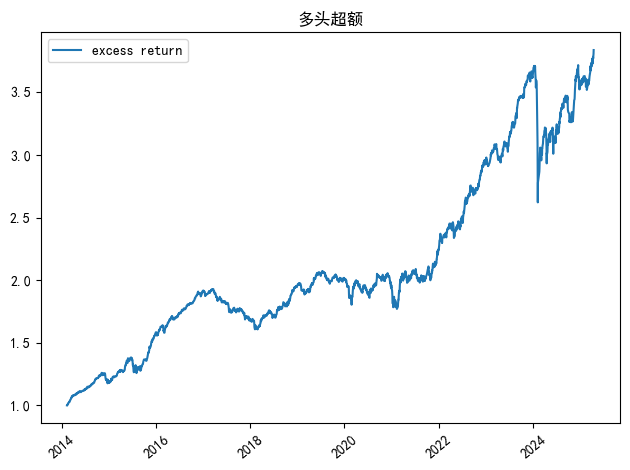

Rank IC: 3.07%
Rank ICIR: 0.47
t值: 24.77
年化收益率: 15.47%
年化波动率: 8.89%
信息比率: 1.74
最大回撤: 33.73%


In [6]:
res3=config.backtest_stand(-voh_cor,top=300,fre='day',stock_pool='888888')
# Rank IC
rank_ic = res3['ic']['ic'].mean()
# Rank ICIR
rank_icir = res3['ic']['ic'].mean() / res3['ic']['ic'].std()
# t值
t_value = res3['ic']['ic'].mean() / (res3['ic']['ic'].std() / np.sqrt(res3['ic']['ic'].count()))
perf = res3['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

load data locally from 2009-01-05 to 2025-04-15
2015-05-28 极端市场，不调仓
2015-06-01 极端市场，不调仓
2015-06-19 极端市场，不调仓
2015-06-26 极端市场，不调仓
2015-06-29 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-07-02 极端市场，不调仓
2015-07-03 极端市场，不调仓
2015-07-06 极端市场，不调仓
2015-07-07 极端市场，不调仓
2015-07-08 极端市场，不调仓
2015-07-09 极端市场，不调仓
2015-07-10 极端市场，不调仓
2015-07-13 极端市场，不调仓
2015-07-14 极端市场，不调仓
2015-07-15 极端市场，不调仓
2015-07-16 极端市场，不调仓
2015-07-17 极端市场，不调仓
2015-07-20 极端市场，不调仓
2015-07-27 极端市场，不调仓
2015-07-28 极端市场，不调仓
2015-07-29 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-08-04 极端市场，不调仓
2015-08-10 极端市场，不调仓
2015-08-18 极端市场，不调仓
2015-08-21 极端市场，不调仓
2015-08-24 极端市场，不调仓
2015-08-25 极端市场，不调仓
2015-08-26 极端市场，不调仓
2015-08-28 极端市场，不调仓
2015-09-01 极端市场，不调仓
2015-09-02 极端市场，不调仓
2015-09-14 极端市场，不调仓
2015-09-15 极端市场，不调仓
2015-09-16 极端市场，不调仓
2015-10-21 极端市场，不调仓
2016-01-04 极端市场，不调仓
2016-01-07 极端市场，不调仓
2016-01-11 极端市场，不调仓
2016-01-26 极端市场，不调仓
2016-02-25 极端市场，不调仓
2018-06-19 极端市场，不调仓
2018-10-11 极端市场，不调仓
2020-02-03 极端市场，不调仓
2025-04-07 极端市场，不调仓
多头超额:
             2014   2015  

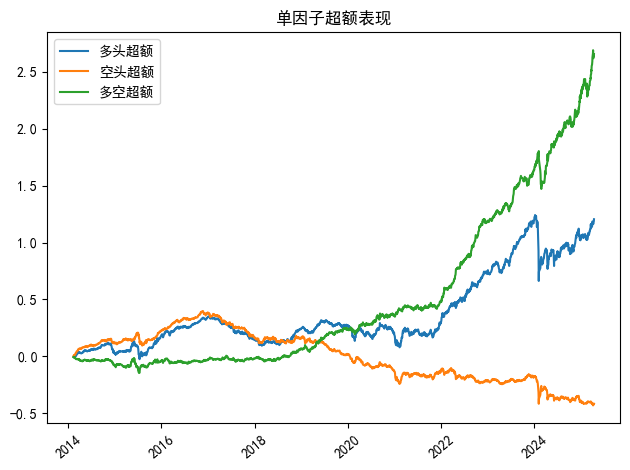

平均单边换手：0.766
年化交易成本:42.641 (未在超额中扣除)


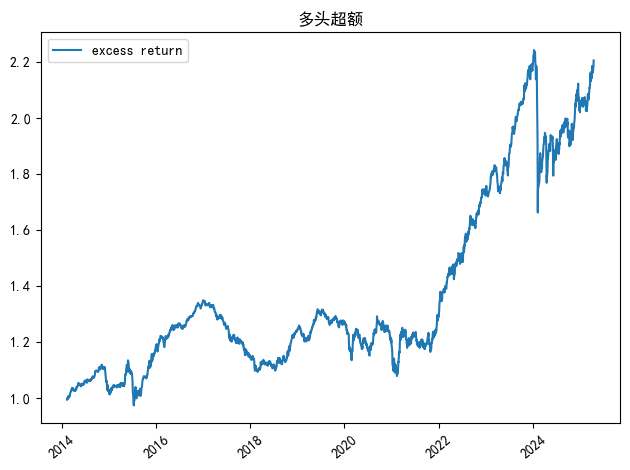

Rank IC: 2.02%
Rank ICIR: 0.33
t值: 17.13
年化收益率: 10.07%
年化波动率: 8.73%
信息比率: 1.15
最大回撤: 29.11%


In [8]:
res4=config.backtest_stand(vol_cor,top=300,fre='day',stock_pool='888888')
# Rank IC
rank_ic = res4['ic']['ic'].mean()
# Rank ICIR
rank_icir = res4['ic']['ic'].mean() / res4['ic']['ic'].std()
# t值
t_value = res4['ic']['ic'].mean() / (res4['ic']['ic'].std() / np.sqrt(res4['ic']['ic'].count()))
perf = res4['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

## 转移熵序列 - 非线性量价因果关系

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm

def safe_qcut(series, q=[0,0.3,0.7,1], labels=[0,1,2]):
    """安全的qcut函数，处理重复值"""
    try:
        # 移除NaN值
        clean_series = series.dropna()
        if len(clean_series) < 10:
            return pd.Series([np.nan] * len(series), index=series.index)
        
        # 检查是否有足够的唯一值
        unique_values = clean_series.nunique()
        if unique_values < 3:
            return pd.Series([np.nan] * len(series), index=series.index)
        
        # 使用qcut，允许重复值
        result = pd.qcut(clean_series, q=q, labels=labels, duplicates='drop')
        return result.reindex(series.index)
    except:
        return pd.Series([np.nan] * len(series), index=series.index)

def calculate_te_vectorized(df, k_range=range(1, 6)):
    """向量化计算转移熵"""
    # 计算滚动指标
    df['rtn_5min'] = df.groupby('stock_code')['return'].rolling(window=5, min_periods=1).sum().reset_index(0, drop=True)
    df['vol_5min'] = df.groupby('stock_code')['volume'].rolling(window=5, min_periods=1).sum().reset_index(0, drop=True)
    
    # 按股票分组进行离散化
    df['rtnStatus'] = df.groupby('stock_code')['rtn_5min'].transform(safe_qcut).astype(float)
    df['volStatus'] = df.groupby('stock_code')['vol_5min'].transform(safe_qcut).astype(float)
    
    # 创建滞后变量
    df['rtnStatus_lag1'] = df.groupby('stock_code')['rtnStatus'].shift(1)
    df['rtnStatus_lag2'] = df.groupby('stock_code')['rtnStatus'].shift(2)
    df['rtnStatus_lag3'] = df.groupby('stock_code')['rtnStatus'].shift(3)
    df['rtnStatus_lag4'] = df.groupby('stock_code')['rtnStatus'].shift(4)
    df['rtnStatus_lag5'] = df.groupby('stock_code')['rtnStatus'].shift(5)
    
    df['volStatus_lag1'] = df.groupby('stock_code')['volStatus'].shift(1)
    df['volStatus_lag2'] = df.groupby('stock_code')['volStatus'].shift(2)
    df['volStatus_lag3'] = df.groupby('stock_code')['volStatus'].shift(3)
    df['volStatus_lag4'] = df.groupby('stock_code')['volStatus'].shift(4)
    df['volStatus_lag5'] = df.groupby('stock_code')['volStatus'].shift(5)
    
    # 计算TE rtn->vol
    TE_rtn2vol_results = {}
    for k in k_range:
        lag_col = f'rtnStatus_lag{k}'
        df_k = df.dropna(subset=[lag_col, 'volStatus'])
        
        if len(df_k) == 0:
            continue
            
        # 使用pivot_table计算联合分布
        joint_counts = df_k.groupby(['stock_code', lag_col, 'volStatus']).size().reset_index(name='count')
        joint_probs = joint_counts.groupby('stock_code')['count'].transform(lambda x: x / x.sum())
        
        # 计算条件分布
        cond_counts = df_k.groupby(['stock_code', lag_col]).size().reset_index(name='cond_count')
        joint_counts = joint_counts.merge(cond_counts, on=['stock_code', lag_col])
        cond_probs = joint_counts['count'] / joint_counts['cond_count']
        
        # 计算边缘分布
        vol_counts = df_k.groupby(['stock_code', 'volStatus']).size().reset_index(name='vol_count')
        vol_probs = vol_counts.groupby('stock_code')['vol_count'].transform(lambda x: x / x.sum())
        
        # 合并所有概率
        result_df = joint_counts.merge(vol_counts, on=['stock_code', 'volStatus'])
        result_df['joint_prob'] = joint_probs
        result_df['cond_prob'] = cond_probs
        result_df['vol_prob'] = vol_probs
        
        # 计算TE
        result_df['te_contribution'] = result_df['joint_prob'] * np.log(
            result_df['cond_prob'] / result_df['vol_prob']
        ).replace([np.inf, -np.inf], 0)
        
        te_by_stock = result_df.groupby('stock_code')['te_contribution'].sum()
        TE_rtn2vol_results[k] = te_by_stock
    
    # 计算TE vol->rtn
    TE_vol2rtn_results = {}
    for k in k_range:
        lag_col = f'volStatus_lag{k}'
        df_k = df.dropna(subset=[lag_col, 'rtnStatus'])
        
        if len(df_k) == 0:
            continue
            
        # 使用pivot_table计算联合分布
        joint_counts = df_k.groupby(['stock_code', lag_col, 'rtnStatus']).size().reset_index(name='count')
        joint_probs = joint_counts.groupby('stock_code')['count'].transform(lambda x: x / x.sum())
        
        # 计算条件分布
        cond_counts = df_k.groupby(['stock_code', lag_col]).size().reset_index(name='cond_count')
        joint_counts = joint_counts.merge(cond_counts, on=['stock_code', lag_col])
        cond_probs = joint_counts['count'] / joint_counts['cond_count']
        
        # 计算边缘分布
        rtn_counts = df_k.groupby(['stock_code', 'rtnStatus']).size().reset_index(name='rtn_count')
        rtn_probs = rtn_counts.groupby('stock_code')['rtn_count'].transform(lambda x: x / x.sum())
        
        # 合并所有概率
        result_df = joint_counts.merge(rtn_counts, on=['stock_code', 'rtnStatus'])
        result_df['joint_prob'] = joint_probs
        result_df['cond_prob'] = cond_probs
        result_df['rtn_prob'] = rtn_probs
        
        # 计算TE
        result_df['te_contribution'] = result_df['joint_prob'] * np.log(
            result_df['cond_prob'] / result_df['rtn_prob']
        ).replace([np.inf, -np.inf], 0)
        
        te_by_stock = result_df.groupby('stock_code')['te_contribution'].sum()
        TE_vol2rtn_results[k] = te_by_stock
    
    # 计算平均TE
    if TE_rtn2vol_results:
        te_rtn2vol_avg = pd.concat(TE_rtn2vol_results.values(), axis=1).mean(axis=1)
    else:
        te_rtn2vol_avg = pd.Series(dtype=float)
        
    if TE_vol2rtn_results:
        te_vol2rtn_avg = pd.concat(TE_vol2rtn_results.values(), axis=1).mean(axis=1)
    else:
        te_vol2rtn_avg = pd.Series(dtype=float)
    
    return te_rtn2vol_avg, te_vol2rtn_avg

def process_and_save_factors():
    """主函数：循环处理文件，计算所有因子，并分别保存"""
    data_dir = r'E:\需要拷的数据\L1_01'
    all_files = sorted(glob.glob(os.path.join(data_dir, '*.feather')))
    
    results_rtn2vol = []
    results_vol2rtn = []
    
    for file in tqdm(all_files, desc="Processing files"):
        try:
            date_str = os.path.basename(file).split('.')[0]
            df = pd.read_feather(file)
            
            # 数据预处理
            df = df[(df['time'] >= 94500) & (df['time'] <= 144500)]
            df['return'] = df.groupby('stock_code')['close'].pct_change()
            df = df.dropna(subset=['return'])
            
            if df.empty:
                continue
            
            # 向量化计算转移熵
            te_rtn2vol, te_vol2rtn = calculate_te_vectorized(df)
            
            # 转换为DataFrame格式
            if not te_rtn2vol.empty:
                daily_df_rtn2vol = te_rtn2vol.to_frame(date_str).T
                daily_df_rtn2vol.columns = daily_df_rtn2vol.columns.astype(str).str.zfill(6)
                results_rtn2vol.append(daily_df_rtn2vol)
            
            if not te_vol2rtn.empty:
                daily_df_vol2rtn = te_vol2rtn.to_frame(date_str).T
                daily_df_vol2rtn.columns = daily_df_vol2rtn.columns.astype(str).str.zfill(6)
                results_vol2rtn.append(daily_df_vol2rtn)
                
        except Exception as e:
            print(f"处理文件 {os.path.basename(file)} 时出错: {e}")
            continue
    
    # 合并并保存结果
    output_path_base = r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages'
    os.makedirs(output_path_base, exist_ok=True)
    
    final_dfs = {}
    
    if results_rtn2vol:
        final_df_rtn2vol = pd.concat(results_rtn2vol, axis=0)
        final_df_rtn2vol.sort_index(inplace=True)
        final_df_rtn2vol.to_pickle(os.path.join(output_path_base, 'TE_rtn2vol.pkl'))
        final_dfs['TE_rtn2vol'] = final_df_rtn2vol
        print(f"因子 'TE_rtn2vol' 已保存，形状: {final_df_rtn2vol.shape}")
    
    if results_vol2rtn:
        final_df_vol2rtn = pd.concat(results_vol2rtn, axis=0)
        final_df_vol2rtn.sort_index(inplace=True)
        final_df_vol2rtn.to_pickle(os.path.join(output_path_base, 'TE_vol2rtn.pkl'))
        final_dfs['TE_vol2rtn'] = final_df_vol2rtn
        print(f"因子 'TE_vol2rtn' 已保存，形状: {final_df_vol2rtn.shape}")
    
    return final_dfs

if __name__ == "__main__":
    final_factors_results = process_and_save_factors()

Processing files: 100%|██████████| 2785/2785 [21:13:55<00:00, 27.45s/it]    


因子 'TE_rtn2vol' 已保存，形状: (2785, 5786)
因子 'TE_vol2rtn' 已保存，形状: (2785, 5786)


In [1]:
import pandas as pd
TE_rtn2vol = pd.read_pickle(r"C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\TE_rtn2vol.pkl")
TE_vol2rt = pd.read_pickle(r"C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages\TE_vol2rtn.pkl")

load data locally from 2009-01-05 to 2025-04-15
2016-02-25 极端市场，不调仓
2018-06-19 极端市场，不调仓
2018-10-11 极端市场，不调仓
2020-02-03 极端市场，不调仓
2025-04-07 极端市场，不调仓
多头超额:
             2016    2017   2018   2019   2020    2021   2022   2023    2024  \
年化超额   0.0718 -0.1856 0.1335 0.0716 0.0477 -0.0168 0.0513 0.1527 -0.0650   
波动率     0.0772  0.1103 0.1138 0.0736 0.0789  0.1164 0.0984 0.0733  0.2620   
最大回撤   0.0700  0.2207 0.1095 0.0673 0.1049  0.1184 0.0760 0.0495  0.3611   
夏普率     0.9301 -1.6830 1.1729 0.9735 0.6045 -0.1441 0.5211 2.0825 -0.2482   
收益回撤比 1.0260 -0.8412 1.2185 1.0643 0.4545 -0.1418 0.6745 3.0845 -0.1801   
半波       0.0488  0.0798 0.0657 0.0459 0.0494  0.0702 0.0582 0.0371  0.1876   
半夏普     1.4702 -2.3258 2.0320 1.5615 0.9655 -0.2391 0.8808 4.1143 -0.3466   

             2025   mean  
年化超额   0.2581 0.0519  
波动率     0.1521 0.1156  
最大回撤   0.0654 0.3611  
夏普率     1.6971 0.4491  
收益回撤比 3.9449 0.1437  
半波       0.0605 0.0703  
半夏普     4.2680 0.7382  


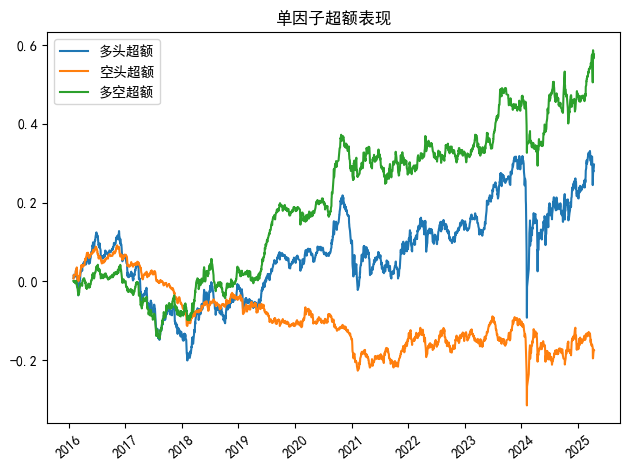

平均单边换手：0.055
年化交易成本:0.044 (未在超额中扣除)


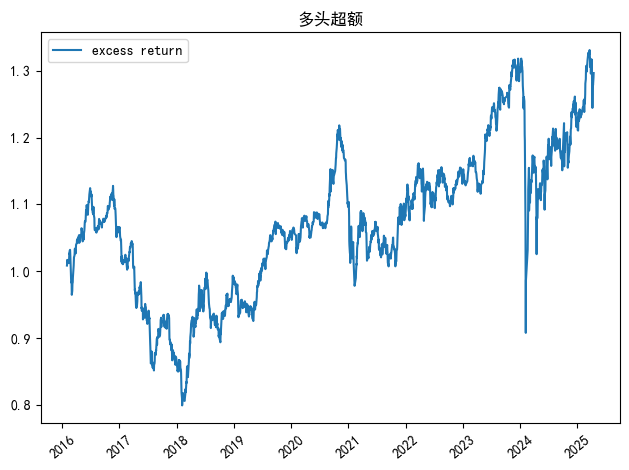

Rank IC: 0.30%
Rank ICIR: 0.06
t值: 2.88
年化收益率: 5.19%
年化波动率: 11.56%
信息比率: 0.45
最大回撤: 36.11%


In [4]:
import config
import numpy as np
TE_rtn2vol.index = TE_rtn2vol.index.astype(str)
res5=config.backtest_stand(-TE_rtn2vol.loc['2016':],top=300,fre='day',stock_pool='888888')
# Rank IC
rank_ic = res5['ic']['ic'].mean()
# Rank ICIR
rank_icir = res5['ic']['ic'].mean() / res5['ic']['ic'].std()
# t值
t_value = res5['ic']['ic'].mean() / (res5['ic']['ic'].std() / np.sqrt(res5['ic']['ic'].count()))
perf = res5['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")